In [3]:
# Load used Python packages
import numpy as np
import pandas as pd
from SimPEG.utils import surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from pymatsolver import Pardiso as Solver
import matplotlib.pyplot as plt
from pymatsolver import Pardiso

## Step1: Load ERT resistivity data

In [5]:
# parse out A, B, M, N electrodes and appparent resistivity 

def run_inversion(fname):
    df = pd.read_csv(fname, encoding= 'unicode_escape')
    n_data = df.shape[0]
    data_io = dc.IO()
    a = np.c_[df['xA (m)'].values, np.zeros(n_data)]
    b = np.c_[df['xB (m)'].values, np.zeros(n_data)]
    m = np.c_[df['xM (m)'].values, np.zeros(n_data)]
    n = np.c_[df['xN (m)'].values, np.zeros(n_data)]
    rho = df['Rho (Ohm.m)'].values # rho: apparent resistivity [ohm-m]
    dev_rho = df['Dev. Rho (%)'].values # rho: apparent resistivity [ohm-m]
    # create a survey object from the data_io object
    survey = data_io.from_abmn_locations_to_survey(
        a, b, m, n, 
        survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
        data_dc=rho, 
        data_dc_type='apparent_resistivity'# input data type
    )
    # plot ert data on a pseudo-section
    # create a 2D tensor mesh
    mesh, _ = data_io.set_mesh(dx=1, dz=0.5, corezlength=25)

    # create a mapping object
    background_conductivity = np.log(1./100)
    nC = int(mesh.n_cells)
    conductivity_map = maps.ExpMap(mesh)

    # define model
    starting_conductivity_model = background_conductivity * np.ones(nC)

    # create a data object
    dc_data = data.Data(survey=survey, dobs=data_io.voltages)
    # assign data uncertainty or error (defined as standard deviation)
    standard_deviation = 0.03 * np.abs(dc_data.dobs) + 1e-3
    dc_data.standard_deviation = standard_deviation

    # create a simulation object
    simulation = dc.simulation_2d.Simulation2DNodal(
        mesh, survey=survey, sigmaMap=conductivity_map, storeJ=True, miniaturize=True
    )
    simulation.solver = Pardiso
    # create a data misfit object
    dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

    # create the regularization (model objective function). here, 'p' defines the
    # the norm of the smallness term, 'px' defines the norm of the smoothness
    # in x and 'pz' defines the norm of the smoothness in z.
    regmap = maps.IdentityMap(mesh=mesh)

    reg = regularization.Sparse(
        mesh,
    #     indActive=ind_active,
        mref=starting_conductivity_model,
        mapping=regmap,
        gradientType="total",
        alpha_s=1e-5,
        alpha_x=1,
        alpha_y=0.5,
    )

    reg.mrefInSmooth = False  # Include reference model in smoothness

    p = 2
    px = 1
    pz = 0
    reg.norms = np.c_[p, px, pz]

    # define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach.
    opt = optimization.InexactGaussNewton(maxIter=40, maxIterCG=30)

    # here we define the inverse problem that is to be solved
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # define DC Inversion Directives
    # ------------------------------
    #
    # here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # reach target misfit for L2 solution, then use IRLS until model stops changing.
    update_IRLS = directives.Update_IRLS(
        max_irls_iterations=25, minGNiter=1, chifact_start=1.0,
        f_min_change=1e-4, fix_Jmatrix=False
    )

    # defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
    beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

    # Options for outputting recovered models and predicted data for each beta.
    save_dict = directives.SaveOutputDictEveryIteration()
    save_dict.outDict = {}
    # Apply and update sensitivity weighting as the model updates
    update_sensitivity_weighting = directives.UpdateSensitivityWeights()

    target = directives.TargetMisfit()
    directives_list = [
    #     update_IRLS,
        starting_beta,
        save_dict,
        beta_schedule,
        target
    ]

    #####################################################################
    # Running the ERT Inversion
    # ------------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

    # Run inversion
    recovered_conductivity_model = dc_inversion.run(starting_conductivity_model) 
    return recovered_conductivity_model, save_dict.outDict

In [6]:
fnames = [
    './data/TN_DD_F0.csv',
    './data/TN_DD_F1.csv',
    './data/TN_DD_F2.csv',
    './data/TN_DD_F3.csv'
]
ms = []
out_dicts = []
for fname in fnames:
    m, out_dict = run_inversion(fname)
    ms.append(m)
    out_dicts.append(out_dict)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.23e+03  3.22e+05  0.00e+00  3.22e+05    2.77e+04      0              
   1  6.15e+02  3.50e+04  2.20e+00  3.63e+04    4.66e+03      0              
   2  3.07e+02  5.01e+03  4.90e+00  6.51e+03    6.63e+02      0   Skip BFGS  
   3  1.54e+02  2.12e+03  8.89e+00  3.48e+03    2.02e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.2178e+04
1 : |xc-x_last| = 1.3367e+01 <= tolX*(1+|x0|) = 5.9057e+01
0 : |proj(x-g)-x|    = 2.0244e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0244e

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.28e+03  3.19e+05  0.00e+00  3.19e+05    2.75e+04      0              
   1  6.39e+02  3.46e+04  2.20e+00  3.60e+04    4.63e+03      0              
   2  3.19e+02  4.97e+03  4.81e+00  6.50e+03    6.54e+02      0   Skip BFGS  
   3  1.60e+02  2.14e+03  8.62e+00  3.52e+03    2.02e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.1929e+04
1 : |xc-x_last| = 1.3219e+01 <= tolX*(1+|x0|) = 5.9057e+01
0 : |proj(x-g)-x|    = 2.0249e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0249e

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.26e+03  3.19e+05  0.00e+00  3.19e+05    2.75e+04      0              
   1  6.30e+02  3.46e+04  2.20e+00  3.59e+04    4.62e+03      0              
   2  3.15e+02  4.93e+03  4.82e+00  6.44e+03    6.53e+02      0   Skip BFGS  
   3  1.57e+02  2.11e+03  8.66e+00  3.47e+03    2.02e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.1905e+04
1 : |xc-x_last| = 1.3253e+01 <= tolX*(1+|x0|) = 5.9057e+01
0 : |proj(x-g)-x|    = 2.0177e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0177e

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.29e+03  3.18e+05  0.00e+00  3.18e+05    2.75e+04      0              
   1  6.47e+02  3.43e+04  2.20e+00  3.57e+04    4.57e+03      0              
   2  3.24e+02  5.06e+03  4.89e+00  6.64e+03    6.56e+02      0   Skip BFGS  
   3  1.62e+02  2.21e+03  8.70e+00  3.62e+03    2.06e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.1833e+04
1 : |xc-x_last| = 1.3301e+01 <= tolX*(1+|x0|) = 5.9057e+01
0 : |proj(x-g)-x|    = 2.0597e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0597e

In [7]:
from matplotlib.colors import LogNorm
from discretize import utils as dis_utils
core_inds, mesh_core = dis_utils.extract_core_mesh(data_io.xyzlim, mesh)

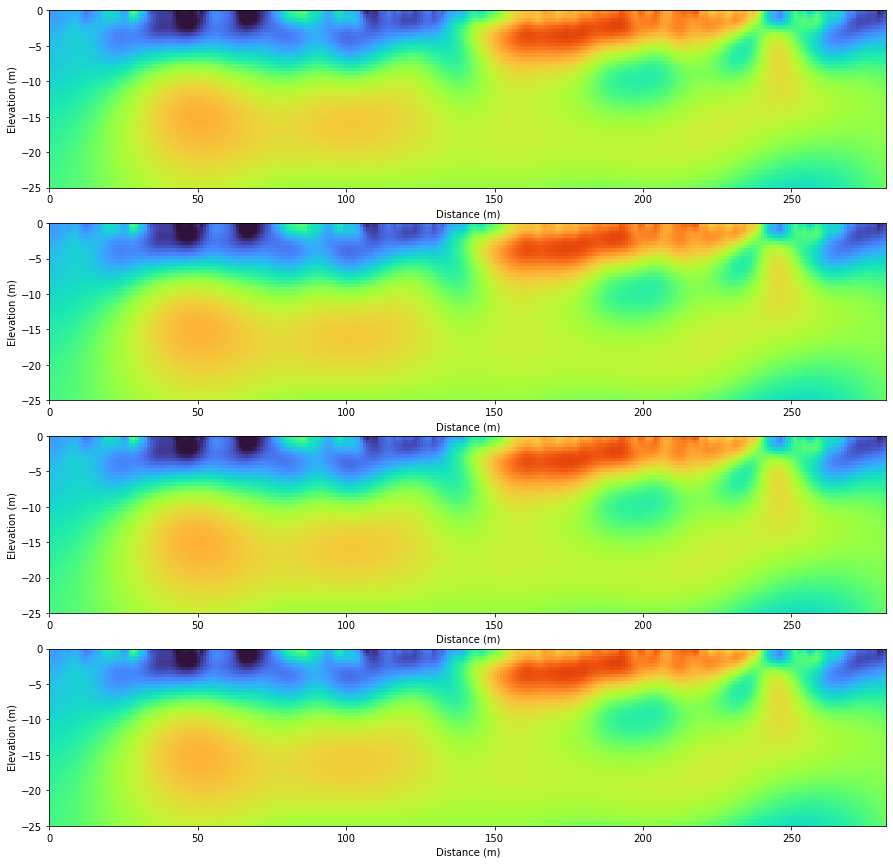

In [13]:
fig, axs = plt.subplots(4,1, figsize=(15, 15))
ii = 0
for ii, ax in enumerate(axs):
    res = 1./(np.exp(ms[ii]))
    out = mesh_core.plot_image(res[core_inds], pcolor_opts={'norm': LogNorm(vmin=20, vmax=1000), 'cmap':'turbo'},ax=ax)
#     ax.set_aspect(1.5)
#     cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, ax=ax)
#     cb.set_label("Resistivity ($\Omega$m)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")

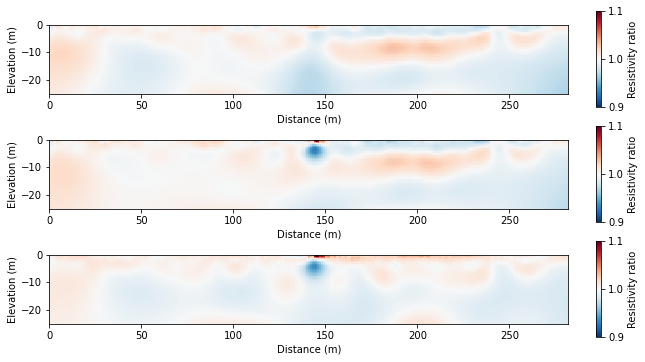

In [32]:
fig, axs = plt.subplots(3,1, figsize=(10, 6))
ii = 0
rho_0 = 1./(np.exp(ms[0]))
for ii, ax in enumerate(axs):
    rho = 1./(np.exp(ms[ii+1]))
    ratio = rho / rho_0
    out = mesh_core.plot_image(ratio[core_inds], pcolor_opts={'cmap':'RdBu_r'},ax=ax, clim=(0.9, 1.1))
    ax.set_aspect(1.5)
    cb = plt.colorbar(out[0], fraction=0.02, ax=ax)
    cb.set_label("Resistivity ratio")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title("")

In [33]:
mesh.nC

16390

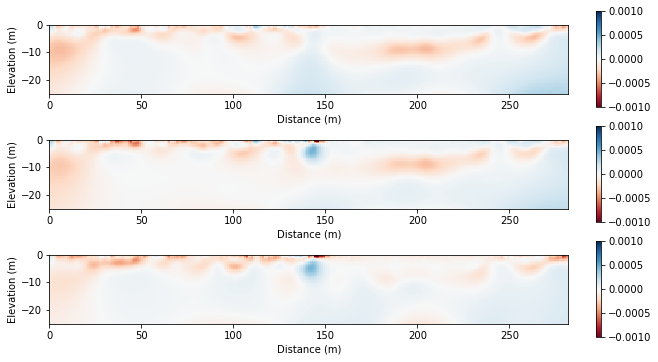

In [28]:
fig, axs = plt.subplots(3,1, figsize=(10, 6))
ii = 0
sigma_0 = (np.exp(ms[0]))
for ii, ax in enumerate(axs):
    sigma = (np.exp(ms[ii+1]))
    diff = sigma - sigma_0
    out = mesh_core.plot_image(diff[core_inds], pcolor_opts={'cmap':'RdBu'},ax=ax, clim=(-0.001, 0.001))
    ax.set_aspect(1.5)
    cb = plt.colorbar(out[0], fraction=0.02, ax=ax)
#     cb.set_label("Resistivity ($\Omega$m)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title("")